# Fake Analysis

This notebook provides a short example of analyzing the fakes from the DEEP data using `analyze_fakes.py`.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from kbmod.analysis.analyze_fakes import FakeInfo, load_fake_info_from_ecsv
from kbmod.analysis.plotting import plot_image
from kbmod.work_unit import WorkUnit

import logging

logging.basicConfig(level=logging.INFO)

Load the test WorkUnit and extract some metadata (t0).

In [7]:
wu_file = "/epyc/projects/kbmod/data/20210908_B1h_047_test_data/20210908_B1h_047.wu"
wu = WorkUnit.from_fits(wu_file)
t0 = wu.get_all_obstimes()[0]

print(f"Loaded {len(wu)} images starting at time {t0}")

INFO:kbmod.work_unit:Loading WorkUnit from FITS file /epyc/projects/kbmod/data/20210908_B1h_047_test_data/20210908_B1h_047.wu.
INFO:kbmod.work_unit:Loading 70 images.
Loading WCS: 100%|██████████| 70/70 [00:00]


Loaded 70 images starting at time 59466.07420776917


Load the fakes data from the ecsv file. For each object (unique orbitid), build a trajectory with from those observations.  We use the `load_fake_info_from_ecsv()` helper function.

In [3]:
fakes_file = "/epyc/projects/kbmod/data/20210908_B1h_047_test_data/20210908_B1h_047_inserted_fakes.ecsv"
fakes_list = load_fake_info_from_ecsv(fakes_file)

INFO:kbmod.analysis.analyze_fakes:Loading fakes from /epyc/projects/kbmod/data/20210908_B1h_047_test_data/20210908_B1h_047_inserted_fakes.ecsv
INFO:kbmod.analysis.analyze_fakes:Loaded the fakes file with 1660 rows.
INFO:kbmod.analysis.analyze_fakes:Found 23 unique objects.


We now have a list of `FakeInfo` objects with the minimal information (the inserted fake's time, RA, and dec).  To get meaningful information, we need to join against what we know about the images. We use the images' WCS to compute the fake object's pixel positions at each time. Then we use those pixel positions to extract stamps and fit a linear trajectory.

Currently we join with each `FakeInfo` object separately (we could add a helper function here if needed).

In [4]:
for fake in fakes_list:
    fake.join_with_workunit(wu, 10)
    print(f"{fake.name}:\n  Fit:{fake.trj}\n  MSE={fake.compute_fit_mse()}")

204287:
  Fit:lh: 0.000000 flux: 0.000000 x: 2622 y: 859 vx: 225.946106 vy: -72.293457 obs_count: 0
  MSE=0.09222501296241285
489097:
  Fit:lh: 0.000000 flux: 0.000000 x: 3902 y: 446 vx: 275.672241 vy: -164.480606 obs_count: 0
  MSE=0.00468429373471563
587985:
  Fit:lh: 0.000000 flux: 0.000000 x: 3748 y: 104 vx: 212.223984 vy: -80.729111 obs_count: 0
  MSE=0.0896562244790423
601439:
  Fit:lh: 0.000000 flux: 0.000000 x: 3791 y: 1597 vx: 290.551575 vy: -109.896027 obs_count: 0
  MSE=0.2016857689806228
1533755:
  Fit:lh: 0.000000 flux: 0.000000 x: 1896 y: 1802 vx: 325.925140 vy: -112.254456 obs_count: 0
  MSE=0.027004381508476744
1668438:
  Fit:lh: 0.000000 flux: 0.000000 x: 4074 y: 1659 vx: 203.226471 vy: -114.468880 obs_count: 0
  MSE=0.24283900340393752
2674005:
  Fit:lh: 0.000000 flux: 0.000000 x: 3776 y: 408 vx: 326.057129 vy: -205.688217 obs_count: 0
  MSE=0.21317736168205265
2706546:
  Fit:lh: 0.000000 flux: 0.000000 x: 745 y: 674 vx: 184.233353 vy: -74.522118 obs_count: 0
  MSE=0.

# Examining Stamps

We can plot the stamps at the raw (x, y) that we computed from the (RA, dec) position and the image WCS. We can also look at the fitted, linear trajectory 

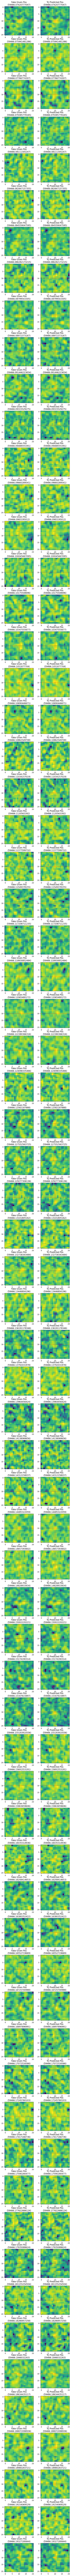

In [5]:
fakes_list[0].compare_all_stamps()